# Who will drop out?

## 1.0 Introduction<br>
>This notebook explores student dropout prediction in online education environments, using the Open University Learning Analytics Dataset (OULAD).  
>The goal is to build an end-to-end analytical workflow — from data ingestion and cleaning to feature engineering, exploratory analysis, and predictive modeling — to understand which factors influence student disengagement and dropout.  
> By combining demographic, academic, and behavioral data, this study aims to identify early warning signs and design insights that could support better retention strategies in distance learning.
## 1.1 About the Open University<br>
> The Open University (OU) is one of the largest and most established distance learning institutions in the United Kingdom, known for its flexible and accessible higher education model.  
> Founded in 1969, it serves hundreds of thousands of students worldwide through fully online courses.<br>
> The OU operates primarily through a Virtual Learning Environment (VLE) — a digital platform where all study materials, assignments, and assessments are hosted, and where student activity is recorded in detail.  
> This unique infrastructure makes it possible to analyze how engagement patterns relate to student performance and dropout rates.
## 1.2 About the OULAD Dataset<br>
> The Open University Learning Analytics Dataset (OULAD) is a public, anonymized dataset released by the Open University for research on distance learning.  
> It includes data from more than 30,000 students across online courses from 2013–2014, covering demographic, academic, and behavioral dimensions of learning.<br>  
> Although collected in the UK, the dataset’s insights into student engagement, dropout, and performance are universally relevant to online education.<br>
> OULAD provides a comprehensive foundation for predictive analytics, combining information about student profiles, course design, assessment results, and virtual learning environment interactions.<br>  

>In this notebook, we will perform the initial data ingestion, cleaning, and preparation steps for the Open University Learning Analytics Dataset (OULAD).
This will ensure that all tables are correctly loaded, formatted, and ready for exploratory analysis and modeling in later stages.<br>

## 1.3 Motivation & Project Scope  

> Beyond the technical challenge, this project is strongly connected to my own experience with online learning.  
> As both a former math teacher and a frequent user of online courses, I have seen how easy it is for motivated students to lose momentum and quietly drop out — not because they lack ability, but because they lack timely support, structure, or a clear sense of progress.  
>  
> This project aims to bridge that gap by turning raw platform logs (clicks, activity days, assessments) into behavioural insights that can be used to detect early disengagement and support students before they abandon the course.  
>  
> The scope of this work is threefold:
> - Build an end-to-end analytical pipeline using the **Open University Learning Analytics Dataset (OULAD)**.  
> - Engineer behavioural and temporal features that describe how students actually interact with the Virtual Learning Environment.  
> - Translate those patterns into **practical retention tools**: an engagement funnel, cohort retention curves, behavioural segments, and a lightweight early-warning model that can be embedded into an educational product.

## 2.0 Data Import and Setup

In [47]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setting display and file paths
pd.set_option('display.max_columns', None)
BASE = Path("..").resolve()
DATA_RAW = BASE / "data" / "raw"
DATA_PROC = BASE / "data" / "processed"
DOCS = BASE / "docs"
DATA_PROC.mkdir(parents=True, exist_ok=True)
DOCS.mkdir(parents=True, exist_ok=True)

# --- Load raw data (not included in repo) ---
required_files = [
    "studentInfo.csv",
    "studentRegistration.csv",
    "courses.csv",
    "assessments.csv",
    "studentAssessment.csv",
    "vle.csv",
    "studentVle.csv",
]

missing = [f for f in required_files if not (DATA_RAW / f).exists()]

if missing:
    raise FileNotFoundError(
        "Raw OULAD files not found in 'data/raw/'.\n"
        "This repository does not include the raw dataset due to size/licensing.\n"
        "Download OULAD from: https://analyse.kmi.open.ac.uk/open_dataset\n"
        f"Missing files: {missing}"
    )



FileNotFoundError: Raw OULAD files not found in 'data/raw/'.
This repository does not include the raw dataset due to size/licensing.
Download OULAD from: https://analyse.kmi.open.ac.uk/open_dataset
Missing files: ['studentInfo.csv', 'studentRegistration.csv', 'courses.csv', 'assessments.csv', 'studentAssessment.csv', 'vle.csv', 'studentVle.csv']

## 2.1 Dataset Overview<br>
> The dataset is composed of seven interrelated tables, each describing a different aspect of the student learning journey:
> - **courses.csv** – List of all modules and presentations (course length, start date).  
> - **assessments.csv** – Metadata for assessments (type, weight, and timing).  
> - **studentInfo.csv** – Student demographics and final outcomes.  
> - **studentRegistration.csv** – Registration and withdrawal dates.  
> - **studentAssessment.csv** – Students’ submissions and grades.  
> - **vle.csv** – Learning materials and their usage timeline.  
> - **studentVle.csv** – Logs of student interactions (clicks) with VLE resources.<br>  
> For the official dataset documentation, refer to the [OULAD data description](https://analyse.kmi.open.ac.uk/open-dataset). <br>
## 2.2 Loading OULAD CSV Files <br>

In [ ]:
student_info      = pd.read_csv(DATA_RAW / "studentInfo.csv")
student_reg       = pd.read_csv(DATA_RAW / "studentRegistration.csv")
courses           = pd.read_csv(DATA_RAW / "courses.csv")
assessments       = pd.read_csv(DATA_RAW / "assessments.csv")
student_assess    = pd.read_csv(DATA_RAW / "studentAssessment.csv")
vle               = pd.read_csv(DATA_RAW / "vle.csv")
student_vle       = pd.read_csv(DATA_RAW / "studentVle.csv")


## 3.0 Data Overview and Validation

In [ ]:
# Quick overview of all loaded DataFrames
dataframes = {
    "student_info": student_info,
    "student_reg": student_reg,
    "courses": courses,
    "assessments": assessments,
    "student_assess": student_assess,
    "vle": vle,
    "student_vle": student_vle
}

for name, df in dataframes.items():
    print(f"\n{name.upper()} - Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    display(df.head(3))




STUDENT_INFO - Shape: 32593 rows, 12 columns


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn



STUDENT_REG - Shape: 32593 rows, 5 columns


,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0



COURSES - Shape: 22 rows, 3 columns


,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268



ASSESSMENTS - Shape: 206 rows, 6 columns


,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0



STUDENT_ASSESS - Shape: 173912 rows, 5 columns


,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0



VLE - Shape: 6364 rows, 6 columns


,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN



STUDENT_VLE - Shape: 10655280 rows, 6 columns


,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1


## 3.1 Summary of Imported Tables<br>
> All seven OULAD tables were successfully loaded.<br>
> Each dataset represents a different part of the online learning process:
> - Student information (profiles and results)
> - Registrations (enrollment timelines)
> - Courses (presentation metadata)
> - Assessments and student submissions (performance)
> - VLE resources and student activity logs (behavioral data)
> 
> Together, these datasets form a complete picture of student engagement, progress, and outcomes.<br>
## 4.0 Data Cleaning and Harmonization<br>
> In this section, we will clean and standardize the data across all OULAD tables.  
> This includes renaming columns, ensuring consistent data types, handling missing values, and preparing the tables for integration in the next step.  
> The goal is to create a uniform, clean base that allows reliable merges and analysis later.<br>
## 4.1 Column Standardization<br>


In [ ]:
# Standardizing column names across all DataFrames
for df in [student_info, student_reg, courses, assessments, student_assess, vle, student_vle]:
    df.columns = df.columns.str.lower().str.strip()

print("✅ Column names standardized successfully.")


✅ Column names standardized successfully.


> All column names were successfully standardized to lowercase and stripped of extra spaces.  
> This ensures consistency across all tables, avoiding merge issues due to case or spacing differences.

## 4.2 Basic Consistency Checks

In [ ]:
# Checking duplicates and missing values in key tables
print("Duplicates in student_info:", student_info.duplicated(subset=["id_student", "code_module", "code_presentation"]).sum())
print("Duplicates in student_reg:", student_reg.duplicated(subset=["id_student", "code_module", "code_presentation"]).sum())

# Checking percentage of missing values
student_info.isna().mean().sort_values(ascending=False).head(10)


Duplicates in student_info: 0
Duplicates in student_reg: 0


imd_band                0.034087
code_module             0.000000
id_student              0.000000
code_presentation       0.000000
gender                  0.000000
region                  0.000000
highest_education       0.000000
age_band                0.000000
num_of_prev_attempts    0.000000
studied_credits         0.000000
dtype: float64

> No duplicate records were found in either the student_info or student_reg tables, confirming data integrity.  
> Only the imd_band column has a small proportion of missing values (~3%), which will be handled in the next step.  
> All other key demographic variables are complete, ensuring reliability for analysis and modeling.

## 4.3 Handling Missing Values

In [ ]:
# Filling missing values in key categorical variables
student_info["imd_band"] = student_info["imd_band"].fillna("Unknown")
student_info["highest_education"] = student_info["highest_education"].fillna("Unknown")
student_info["gender"] = student_info["gender"].fillna("U")  # U = unspecified


## 4.4 Fixing Registration Dates

> The date_registration and date_unregistration columns represent the number of days relative to the course start date.  
> Negative values indicate registration before the course started.  
> We will keep them as numeric for now, since this relative time is useful for analysis.

In [ ]:
# Converting to numeric type
for col in ["date_registration", "date_unregistration"]:
    student_reg[col] = pd.to_numeric(student_reg[col], errors="coerce")


## 4.5 Data Sanity Checks (Ranges, Unique Values)

In [ ]:
# Quick inspection of unique values in key categorical variables
print(student_info["final_result"].value_counts())
print(student_info["age_band"].unique())
print(student_info["imd_band"].unique())


final_result
Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: count, dtype: int64
['55<=' '35-55' '0-35']
['90-100%' '20-30%' '30-40%' '50-60%' '80-90%' '70-80%' 'Unknown' '60-70%'
 '40-50%' '10-20' '0-10%']


> The final_result variable is well-distributed across four categories, with a significant proportion of students who withdrew (~31%).  
> The age and income distributions appear consistent with the expected segmentation of UK adult learners.  
> These results confirm the dataset’s richness and suitability for dropout and retention analysis.

## 4.6 Merge Student, Registration and Course Tables

>These three tables share the same keys: id_student, code_module, and code_presentation.  
>We will merge them to form a unified student-course dataset, containing demographic, academic, and enrollment information.

In [ ]:
# Defining key columns
KEYS = ["id_student", "code_module", "code_presentation"]

# Performing the merge
student_base = (
    student_info
    .merge(student_reg, on=KEYS, how="left")
    .merge(courses, on=["code_module", "code_presentation"], how="left")
)

print("✅ Merge completed successfully.")
print("Shape:", student_base.shape)
student_base.head(3)


✅ Merge completed successfully.
Shape: (32593, 15)


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,module_presentation_length
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,268
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,268
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,268


>The merge between student_info, student_reg, and courses was successful, producing a unified dataset with 32,593 records and 15 features.  
>This consolidated table combines student demographics, registration details, and course metadata — forming the analytical foundation for the next steps.

## 4.7 Summary

>All cleaning and harmonization steps were executed successfully.  
>The dataset is now fully standardized, free from duplicates, and integrated across key tables.  
>The unified dataset (student_base) provides a reliable base for exploring engagement behavior and modeling dropout probability.


## 5.0 Exploratory Data Analysis (EDA)

>This section explores key demographic, socioeconomic, and academic variables to identify patterns related to student dropout and performance.  
Through visual analysis of outcomes, gender differences, age distribution, socioeconomic background, and correlations between numeric features,  
we build the foundation for understanding which factors may influence engagement and final results.


In [ ]:
# --- Custom Project Color Palette ---
NAVY = "#0A3756"
BLUE = "#4CA3DD"
YELLOW = "#E8AA3A"
WHITE = "#F5F7FA"
GRAPHITE = "#2A2E33"

custom_palette = [NAVY, BLUE, YELLOW]

# Global Plot Style
sns.set_palette(custom_palette)

plt.rcParams["figure.facecolor"]   = WHITE
plt.rcParams["axes.facecolor"]     = WHITE
plt.rcParams["text.color"]         = GRAPHITE
plt.rcParams["axes.labelcolor"]    = GRAPHITE
plt.rcParams["xtick.color"]        = GRAPHITE
plt.rcParams["ytick.color"]        = GRAPHITE
plt.rcParams["axes.titlecolor"]    = NAVY


## 5.1 Distribution of Final Results

>Understanding final outcomes ("Pass", "Fail", "Withdrawn", "Distinction") is crucial for defining dropout behaviour.  
>This provides the baseline proportions for future modelling and segmentation.


C:\Users\marce\AppData\Local\Temp\ipykernel_40388\3656317428.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


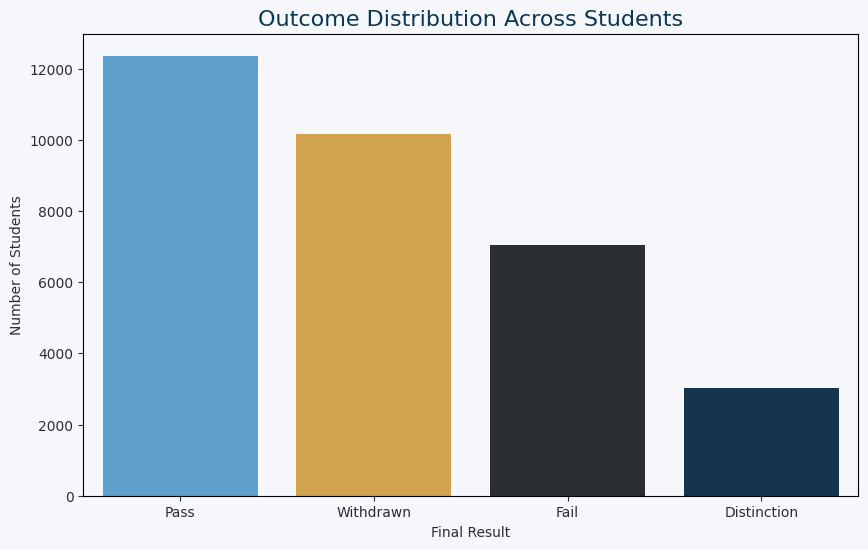

In [ ]:
# Custom colors for each final result category
result_colors = {
    "Withdrawn": YELLOW,
    "Fail": GRAPHITE,
    "Pass": BLUE,
    "Distinction": NAVY
}

order = ["Pass", "Withdrawn", "Fail", "Distinction"]

plt.figure(figsize=(10,6))
sns.countplot(
    data=student_base,
    x="final_result",
    order=order,
    palette=[result_colors[x] for x in order]
)

plt.title("Outcome Distribution Across Students", fontsize=16)
plt.xlabel("Final Result")
plt.ylabel("Number of Students")
plt.xticks(rotation=0)
plt.show()


> A large proportion of students either withdraw or fail, together exceeding half of the total population. Pass is the most common result, while Distinction represents only a small share of high-performing students. The high withdrawal rate highlights that disengagement and dropout are central behaviours in this dataset, reinforcing the importance of building early-warning predictive models.

## 5.2 Final Result by Gender

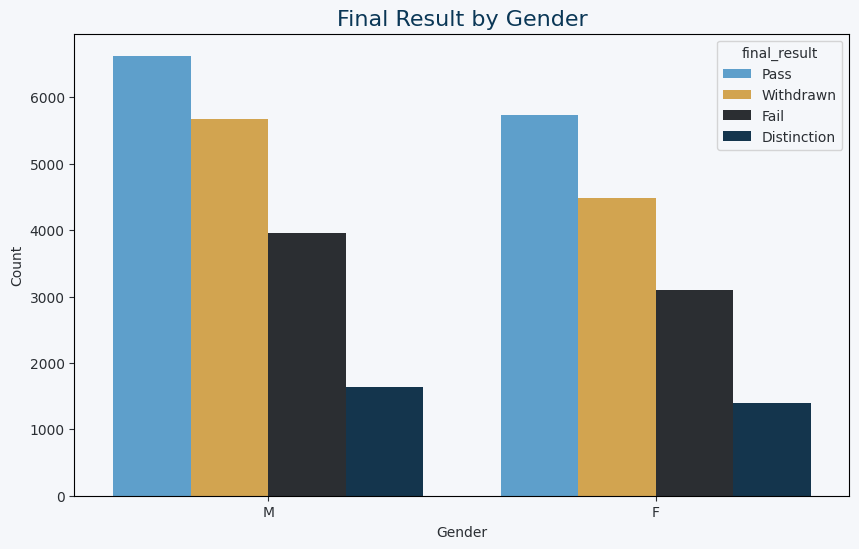

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(
    data=student_base,
    x="gender",
    hue="final_result",
    hue_order=order,
    palette=[result_colors[x] for x in order]
)

plt.title("Final Result by Gender", fontsize=16)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


> Both genders follow similar outcome patterns, though with subtle differences. Women tend to achieve more Pass results and slightly fewer Withdrawals, whereas men show higher proportions of both Fail and Distinction. This suggests that gender may influence performance variability but is not a primary driver of dropout behaviour. Overall, differences exist but are not sharp enough to define gender as a key risk factor.

## 5.3 Age Band Distribution

> Student age is a key demographic feature that may influence engagement patterns.  
This chart shows how age groups are represented across the dataset.


C:\Users\marce\AppData\Local\Temp\ipykernel_40388\3674164020.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\marce\AppData\Local\Temp\ipykernel_40388\3674164020.py:6: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(


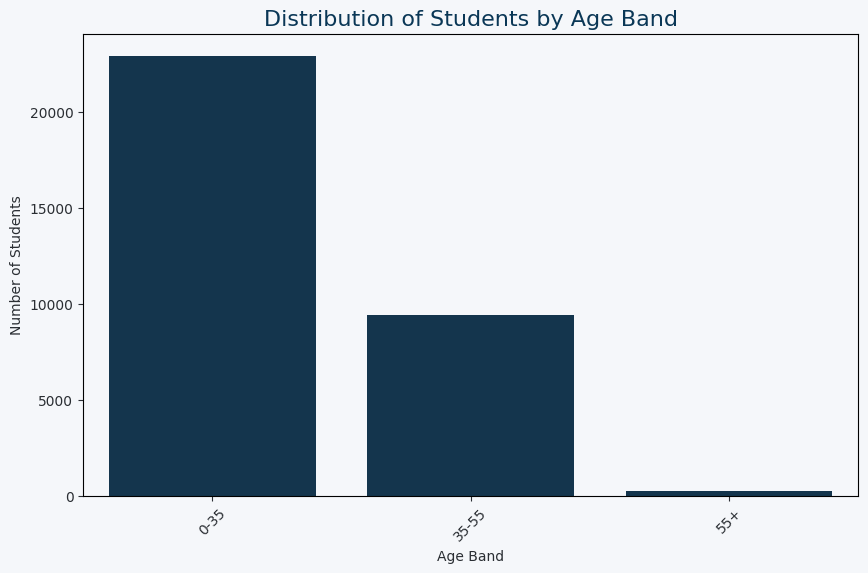

In [ ]:
student_base["age_band"] = student_base["age_band"].replace({"55<=": "55+"})

age_order = ["0-35", "35-55", "55+"]

plt.figure(figsize=(10,6))
sns.countplot(
    data=student_base,
    x="age_band",
    order=age_order,
    palette=[NAVY]
)

plt.title("Distribution of Students by Age Band", fontsize=16)
plt.xlabel("Age Band")
plt.ylabel("Number of Students")
plt.xticks(rotation=45)
plt.show()


> The dataset is strongly concentrated in the 0–35 age group, which accounts for the vast majority of learners. Students aged 35–55 represent a smaller but still meaningful segment, while the 55+ group is minimal. This distribution reflects the profile of a younger online-learning population and suggests that most dropout and performance patterns observed later will be dominated by younger students’ behaviour. Age remains relevant, but heavily unbalanced across categories.

## 5.4 Previous Attempts vs Final Result

> Students with repeated attempts may present higher dropout risk.  
This visualization examines the relationship between *num_of_prev_attempts* and their outcomes.


C:\Users\marce\AppData\Local\Temp\ipykernel_40388\333116572.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


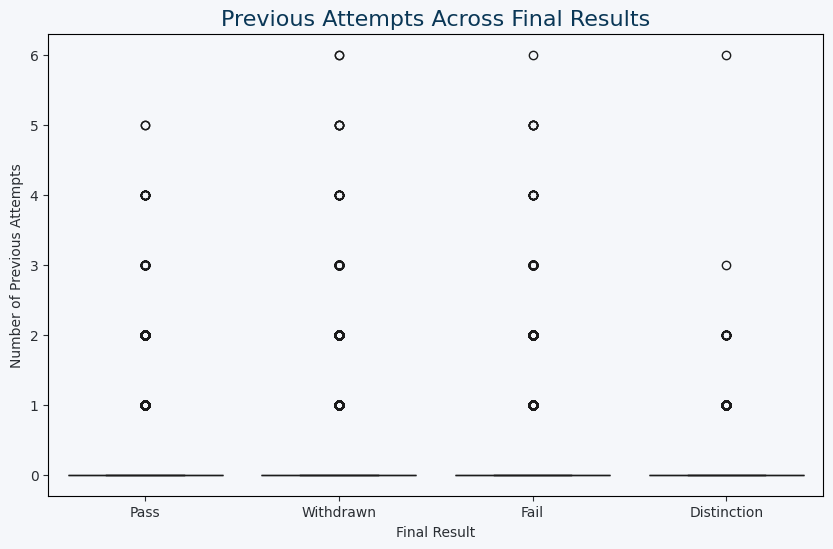

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=student_base,
    x="final_result",
    y="num_of_prev_attempts",
    order=order,
    palette=[result_colors[x] for x in order]
)

plt.title("Previous Attempts Across Final Results", fontsize=16)
plt.xlabel("Final Result")
plt.ylabel("Number of Previous Attempts")
plt.show()


> Most students have no previous attempts, but repeated attempts are more common among those who withdraw or fail. Distinction students rarely repeat modules, indicating stronger initial performance. This pattern suggests that prior attempts are a useful indicator of risk: students retaking a module are more likely to continue struggling, and may benefit from early targeted interventions or academic support.

## 5.5 Studied Credits vs Final Result

> Higher study loads may contribute to performance differences and impact dropout risk.  
This plot visualizes how credit load varies across different final outcomes.


C:\Users\marce\AppData\Local\Temp\ipykernel_40388\3975595529.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


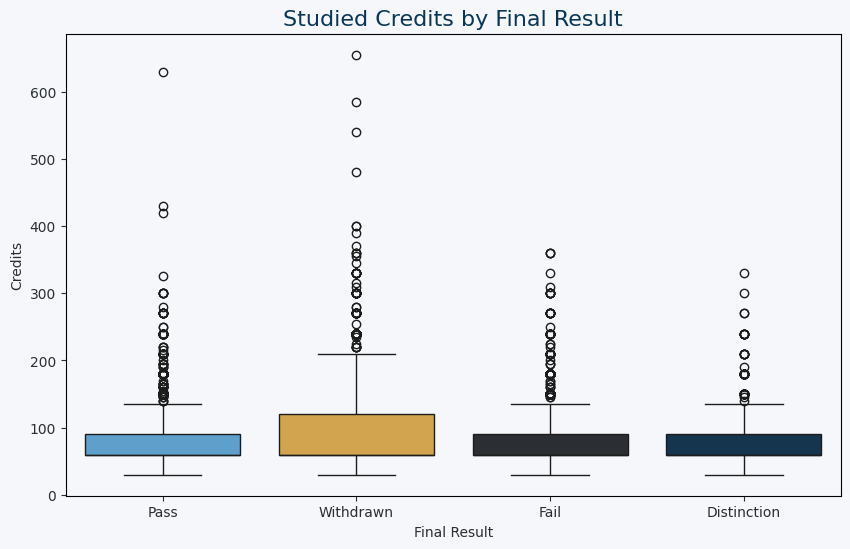

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=student_base,
    x="final_result",
    y="studied_credits",
    order=order,
    palette=[result_colors[x] for x in order]
)

plt.title("Studied Credits by Final Result", fontsize=16)
plt.xlabel("Final Result")
plt.ylabel("Credits")
plt.show()


> Studied credits show meaningful differences across final outcomes. Withdrawn students display the widest credit variation, including a notable number of high-credit cases, suggesting that heavier workloads may contribute to disengagement. Pass and Fail groups share similar median credit loads, while Distinction students tend to stay within balanced credit levels. These patterns indicate that credit load may interact with performance — especially when excessive — and could serve as a useful input for dropout-risk modelling.

## 5.6 Socioeconomic Status (IMD Band)

IMD (Index of Multiple Deprivation) represents socioeconomic conditions, which often influence dropout likelihood.


In [ ]:
print(sorted(student_base["imd_band"].unique()))


['0-10%', '10-20', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%', 'Unknown']


C:\Users\marce\AppData\Local\Temp\ipykernel_40388\655799655.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\marce\AppData\Local\Temp\ipykernel_40388\655799655.py:2: UserWarning: 
The palette list has fewer values (1) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(


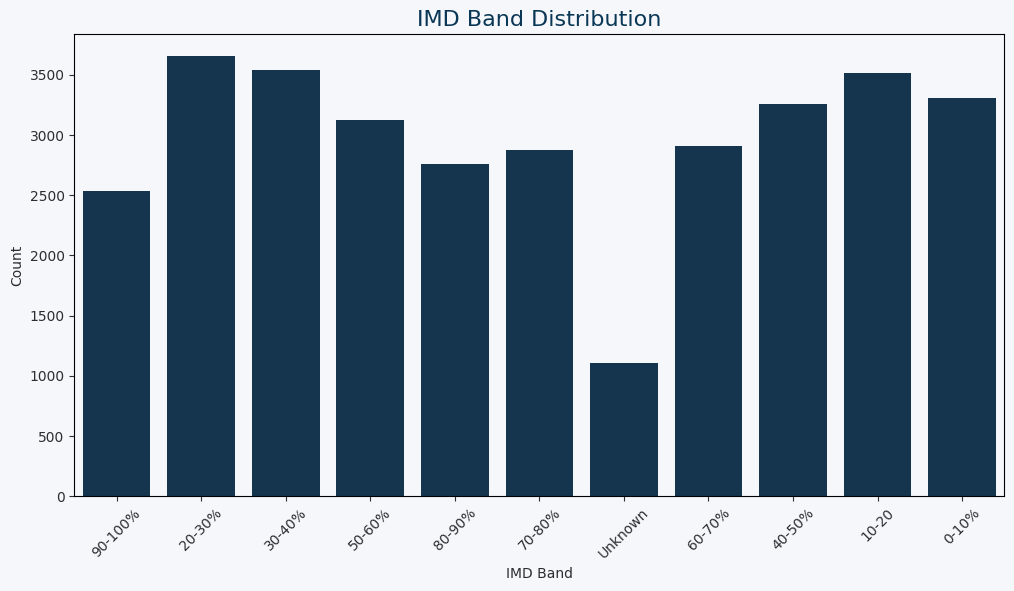

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(
    data=student_base,
    x="imd_band",
    palette=[NAVY]
)

plt.title("IMD Band Distribution", fontsize=16)
plt.xlabel("IMD Band")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()



> IMD Band distribution reveals that the student population is spread across a wide range of socioeconomic backgrounds, 
with no single band dominating the dataset. However, the “Unknown” category stands out as significantly smaller, 
indicating missing socioeconomic data for some learners. This diversity supports broader analysis of how deprivation levels may 
influence dropout risk, engagement, or performance patterns.


## 5.7 Correlation Heatmap (Numeric Features Only)

> This heatmap shows linear relationships between numeric variables,  
helping identify potential predictors for the dropout model.


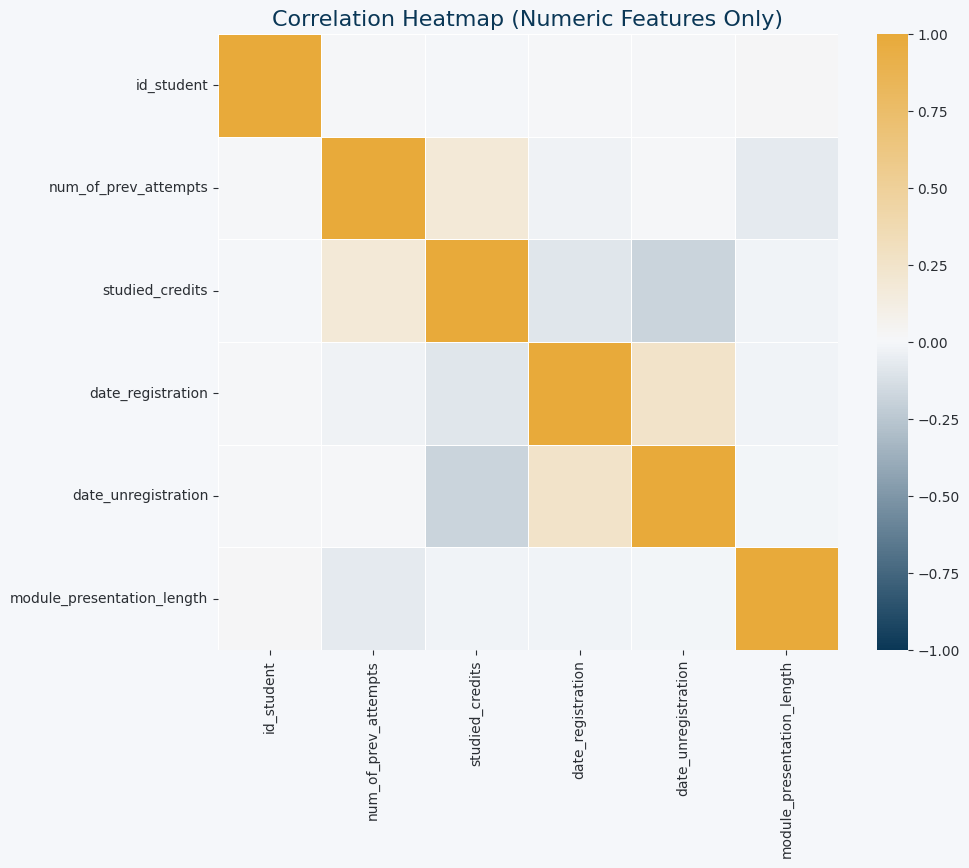

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

corr = student_base.select_dtypes(include=["int64", "float64"]).corr()

corr_cmap = LinearSegmentedColormap.from_list(
    "corr_cmap", [NAVY, WHITE, YELLOW]
)

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=False,
    cmap=corr_cmap,
    center=0,
    vmin=-1, vmax=1,          # <- importante!
    linewidths=.5
)
plt.title("Correlation Heatmap (Numeric Features Only)", fontsize=16)
plt.show()



> The correlation matrix shows weak linear relationships among the numeric features, indicating that no single variable dominates as a strong predictor on its own.  
A moderate positive correlation appears between date_unregistration and date_registration, which is expected since both relate to module timing. 
Features such as studied_credits and num_of_prev_attempts show near-zero correlation with others, suggesting they may influence outcomes in nonlinear or interaction-driven ways.  
These insights highlight the importance of using more complex modeling techniques later on, such as tree-based classifiers, to uncover deeper patterns beyond simple linear relationships.


## 5.8 Summary of Key Insights from Exploratory Analysis

> This section summarizes the main patterns observed across demographic, academic, and socioeconomic variables. These insights provide the foundation for understanding student behaviour and guiding the next stages of feature engineering and predictive modeling.

> Key findings include:

> - High withdrawal rates: Withdrawn is one of the largest outcome categories, reinforcing dropout as a central challenge in distance learning.

> - Gender differences are modest: Both genders show similar outcome patterns; any differences are subtle and unlikely to be the main driver of dropout.

> - Age distribution is skewed toward younger students: Most learners are aged 0–35, so engagement patterns largely reflect younger adults.

> - Previous attempts may signal risk: Repeated attempts appear more often among students who withdraw or fail, suggesting the need for earlier support for retakers.

> - Study load varies, especially among withdrawals: Credit load is broadly similar across groups, but withdrawn students show wider variation, including high-load cases.

> - Socioeconomic distribution (IMD Band): Students span diverse deprivation bands, enabling analysis of how socioeconomic context may relate to outcomes.

> - Weak linear correlations among numeric features: No single numeric variable dominates linearly, supporting the use of non-linear models to capture combined behaviour patterns.

## 6.0 Feature Engineering & Engagement Metrics
> Feature engineering plays a crucial role in transforming raw log data into actionable insights.
In the context of online learning, behavioural indicators — such as activity frequency, consistency, and interaction patterns — are often strong predictors of student success or disengagement. <br>
> In this section, we will build engagement-related features derived from VLE interaction logs and assessment behaviour.<br>
> These features will later support deeper exploratory analysis, retention studies, and the development of a churn-risk prediction model.
## 6.1 Creating Engagement Aggregates (Clicks & VLE Interaction)
> In this step, we extract core behavioural metrics from the studentVLE table.<br>
> These metrics summarise how actively each student interacted with the learning platform throughout the module.

In [ ]:
# Copy student_vle to avoid modifying raw data
vle_data = student_vle.copy()

# Aggregate total clicks per student
eng_total = vle_data.groupby(["code_module", "code_presentation", "id_student"])["sum_click"].sum().reset_index()
eng_total.rename(columns={"sum_click": "total_clicks"}, inplace=True)

# Number of active days (days where student clicked)
eng_active_days = vle_data.groupby(["code_module", "code_presentation", "id_student"])["date"].nunique().reset_index()
eng_active_days.rename(columns={"date": "active_days"}, inplace=True)

# Average clicks per active day
eng_avg_clicks = vle_data.groupby(["code_module", "code_presentation", "id_student"])["sum_click"].mean().reset_index()
eng_avg_clicks.rename(columns={"sum_click": "avg_clicks_per_day"}, inplace=True)

# Maximum clicks in a single day
eng_max_clicks = vle_data.groupby(["code_module", "code_presentation", "id_student"])["sum_click"].max().reset_index()
eng_max_clicks.rename(columns={"sum_click": "max_clicks_per_day"}, inplace=True)

# First and last interaction dates
eng_dates = vle_data.groupby(["code_module", "code_presentation", "id_student"])["date"].agg(["min", "max"]).reset_index()
eng_dates.rename(columns={"min": "first_click_day", "max": "last_click_day"}, inplace=True)

# Merge all engagement features
engagement_features = eng_total \
    .merge(eng_active_days, on=["code_module", "code_presentation", "id_student"], how="left") \
    .merge(eng_avg_clicks, on=["code_module", "code_presentation", "id_student"], how="left") \
    .merge(eng_max_clicks, on=["code_module", "code_presentation", "id_student"], how="left") \
    .merge(eng_dates, on=["code_module", "code_presentation", "id_student"], how="left")

engagement_features.head()


,code_module,code_presentation,id_student,total_clicks,active_days,avg_clicks_per_day,max_clicks_per_day,first_click_day,last_click_day
0,AAA,2013J,11391,934,40,4.765306,76,-5,253
1,AAA,2013J,28400,1435,80,3.337209,23,-10,239
2,AAA,2013J,30268,281,12,3.697368,23,-10,12
3,AAA,2013J,31604,2158,123,3.254902,22,-10,264
4,AAA,2013J,32885,1034,70,2.937500,22,-10,247


> These aggregated metrics give a first high-level view of how students interact with the platform. <br>
> We can already observe substantial variation in total clicks, intensity (max clicks per day), and consistency (active days). <br>
> These behavioural indicators will later help identify distinct engagement profiles and detect early signs of disengagement. <br>
## 6.2 Temporal Engagement Metrics (Early vs. Late Activity)
> Understanding *when* students engage with the Virtual Learning Environment (VLE) is just as important as measuring *how much* they engage. <br>
> Temporal engagement features help identify behavioural patterns such as early disengagement, late bursts of activity, or minimal interaction during 
critical course periods.
<br><br>
> In this section, we extract time-based indicators that quantify how students distribute their activity over the duration of the module. <br>
> These metrics are valuable for identifying early warning signs of dropout and supporting retention-focused decision-making.


In [ ]:
vle_temp = student_vle.copy()

# Define windows
EARLY_WINDOW = 14
LATE_WINDOW = 14

# Module duration lookup
module_len = courses[["code_module", "code_presentation", "module_presentation_length"]]

# Merge length into vle data
vle_temp = vle_temp.merge(
    module_len,
    on=["code_module", "code_presentation"],
    how="left"
)

# Early engagement: first 14 days
early_eng = vle_temp[vle_temp["date"] <= EARLY_WINDOW] \
    .groupby(["code_module", "code_presentation", "id_student"])["sum_click"] \
    .sum().reset_index()
early_eng.rename(columns={"sum_click": "early_clicks"}, inplace=True)

# Late engagement: last 14 days
vle_temp["is_late"] = vle_temp.apply(
    lambda row: row["date"] >= (row["module_presentation_length"] - LATE_WINDOW), axis=1
)

late_eng = vle_temp[vle_temp["is_late"] == True] \
    .groupby(["code_module", "code_presentation", "id_student"])["sum_click"] \
    .sum().reset_index()

late_eng.rename(columns={"sum_click": "late_clicks"}, inplace=True)

# Longest inactivity gap
def longest_gap(dates):
    dates = sorted(dates)
    gaps = [j - i for i, j in zip(dates[:-1], dates[1:])]
    return max(gaps) if gaps else 0

gap_df = vle_temp.groupby(
    ["code_module", "code_presentation", "id_student"]
)["date"].apply(longest_gap).reset_index()
gap_df.rename(columns={"date": "longest_inactive_gap"}, inplace=True)

# Merge temporal metrics
temporal_features = early_eng \
    .merge(late_eng, on=["code_module", "code_presentation", "id_student"], how="left") \
    .merge(gap_df, on=["code_module", "code_presentation", "id_student"], how="left")

# Fill missing late_clicks with 0
temporal_features["late_clicks"] = temporal_features["late_clicks"].fillna(0)

temporal_features.head()


,code_module,code_presentation,id_student,early_clicks,late_clicks,longest_inactive_gap
0,AAA,2013J,11391,301,0.0,24
1,AAA,2013J,28400,456,0.0,14
2,AAA,2013J,30268,281,0.0,5
3,AAA,2013J,31604,349,3.0,10
4,AAA,2013J,32885,472,0.0,20


> The engineered temporal engagement table now summarises, for each student and presentation, how activity is distributed over time. For every learner we can see how many clicks happen in the early part of the module (`early_clicks`), how much engagement is concentrated towards the end (`late_clicks`), and the longest period with no activity at all (`longest_inactive_gap`). In the sample above, students already show substantial early engagement and inactivity gaps ranging from 5 to more than 20 days, which can be used as potential early-warning signals for dropout risk.


## 6.3 Assessment Performance Features

> Assessments are central to academic success, so here we summarise each student’s assessment behaviour across a module presentation. We create features such as the total number of assessments taken, average/max/min score, variability in performance, and counts of failed or missed assessments. These indicators help distinguish consistent performers from struggling or disengaged students and will be key inputs for the churn-risk model.



In [ ]:
# Merge student assessment records with assessment metadata
assess_data = student_assess.merge(
    assessments[["id_assessment", "code_module", "code_presentation", "assessment_type", "date", "weight"]],
    on="id_assessment",
    how="left"
)

# Replace -1 scores (not submitted / missing) with NaN for numeric calculations
assess_data["clean_score"] = assess_data["score"].replace(-1, np.nan)

# Flags for missed and failed assessments
assess_data["is_missed"] = (assess_data["score"] == -1).astype(int)
assess_data["is_failed"] = assess_data["clean_score"].lt(40).astype(int)

# Aggregate assessment performance per student and presentation
assess_performance = assess_data.groupby(
    ["code_module", "code_presentation", "id_student"],
    as_index=False
).agg(
    total_assessments=("id_assessment", "count"),
    avg_score=("clean_score", "mean"),
    max_score=("clean_score", "max"),
    min_score=("clean_score", "min"),
    score_variability=("clean_score", "std"),
    num_failed_assessments=("is_failed", "sum"),
    num_missed_assessments=("is_missed", "sum")
)

assess_performance.head()


,code_module,code_presentation,id_student,total_assessments,avg_score,max_score,min_score,score_variability,num_failed_assessments,num_missed_assessments
0,AAA,2013J,11391,5,82.0,85.0,78.0,3.082207,0,0
1,AAA,2013J,28400,5,66.4,70.0,60.0,4.335897,0,0
2,AAA,2013J,31604,5,76.0,88.0,71.0,6.892024,0,0
3,AAA,2013J,32885,5,54.4,75.0,30.0,20.513410,2,0
4,AAA,2013J,38053,5,68.0,79.0,50.0,10.977249,0,0


> The aggregated assessment features highlight clear differences in performance profiles. While some students maintain relatively high average scores in the 70–80 range with no failed or missed assessments, others show lower averages and already accumulate multiple failed assessments despite having taken the same number of tasks. The score_variability column captures how stable each student’s performance is over time, helping to separate consistently strong learners from those whose results are more erratic and potentially at risk.

## 6.4 Creating the Unified Feature Dataset
> After extracting engagement, temporal behaviour, and assessment performance metrics independently, the next step is to consolidate all engineered features into a single analytical dataset.
> This unified table will serve as the foundation for exploratory analysis, retention pattern investigation, and later churn-risk modeling.
> By merging all feature groups on the shared keys (code_module, code_presentation, id_student), we ensure that each student record contains all behavioural, temporal, and performance indicators required for deeper insights.

In [ ]:
# Start with the core demographic + registration + course base
feature_dataset = student_base.copy()

# Merge engagement aggregates
feature_dataset = feature_dataset.merge(
    engagement_features,
    on=["code_module", "code_presentation", "id_student"],
    how="left"
)

# Merge temporal engagement features
feature_dataset = feature_dataset.merge(
    temporal_features,
    on=["code_module", "code_presentation", "id_student"],
    how="left"
)

# Merge assessment performance features
feature_dataset = feature_dataset.merge(
    assess_performance,
    on=["code_module", "code_presentation", "id_student"],
    how="left"
)

# Quick preview
feature_dataset.head()


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,module_presentation_length,total_clicks,active_days,avg_clicks_per_day,max_clicks_per_day,first_click_day,last_click_day,early_clicks,late_clicks,longest_inactive_gap,total_assessments,avg_score,max_score,min_score,score_variability,num_failed_assessments,num_missed_assessments
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55+,0,240,N,Pass,-159.0,NaN,268,934.0,40.0,4.765306,76.0,-5.0,253.0,301.0,0.0,24.0,5.0,82.0,85.0,78.0,3.082207,0.0,0.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,268,1435.0,80.0,3.337209,23.0,-10.0,239.0,456.0,0.0,14.0,5.0,66.4,70.0,60.0,4.335897,0.0,0.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,268,281.0,12.0,3.697368,23.0,-10.0,12.0,281.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,268,2158.0,123.0,3.254902,22.0,-10.0,264.0,349.0,3.0,10.0,5.0,76.0,88.0,71.0,6.892024,0.0,0.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,268,1034.0,70.0,2.937500,22.0,-10.0,247.0,472.0,0.0,20.0,5.0,54.4,75.0,30.0,20.513410,2.0,0.0


> The merged dataset successfully integrates all relevant student-level information, producing a comprehensive table with over 30 features capturing demographic factors, academic history, VLE engagement intensity, temporal interaction patterns, and assessment performance. This enriched structure enables deeper insight into how behaviour and performance relate to student outcomes. The presence of indicators such as inactivity gaps, early/late engagement, and failed assessments creates a strong analytical base for identifying drivers of dropout and building predictive models in subsequent sections.

## 6.5 Feature Importance Screening (Pre-Model Insights)
> Before training any predictive model, it is essential to evaluate how the engineered behavioural, temporal, and academic features relate to final student outcomes.
This step provides business-friendly insight into which characteristics most clearly differentiate students who pass from those who withdraw or fail.

> In this section, we compute correlations for numeric features and perform statistical comparisons across outcome groups. These findings help validate our feature engineering, guide model selection, and highlight early risk indicators that institutions can act upon.

### 6.5.1 Correlation Analysis for Numeric Features

> To better understand how the engineered features relate to each other and to the target outcome,  
we compute a correlation matrix across all numeric variables, including an encoded version of the final result.  
> This helps identify potential multicollinearity and highlights which features may be more strongly associated with student success or dropout.


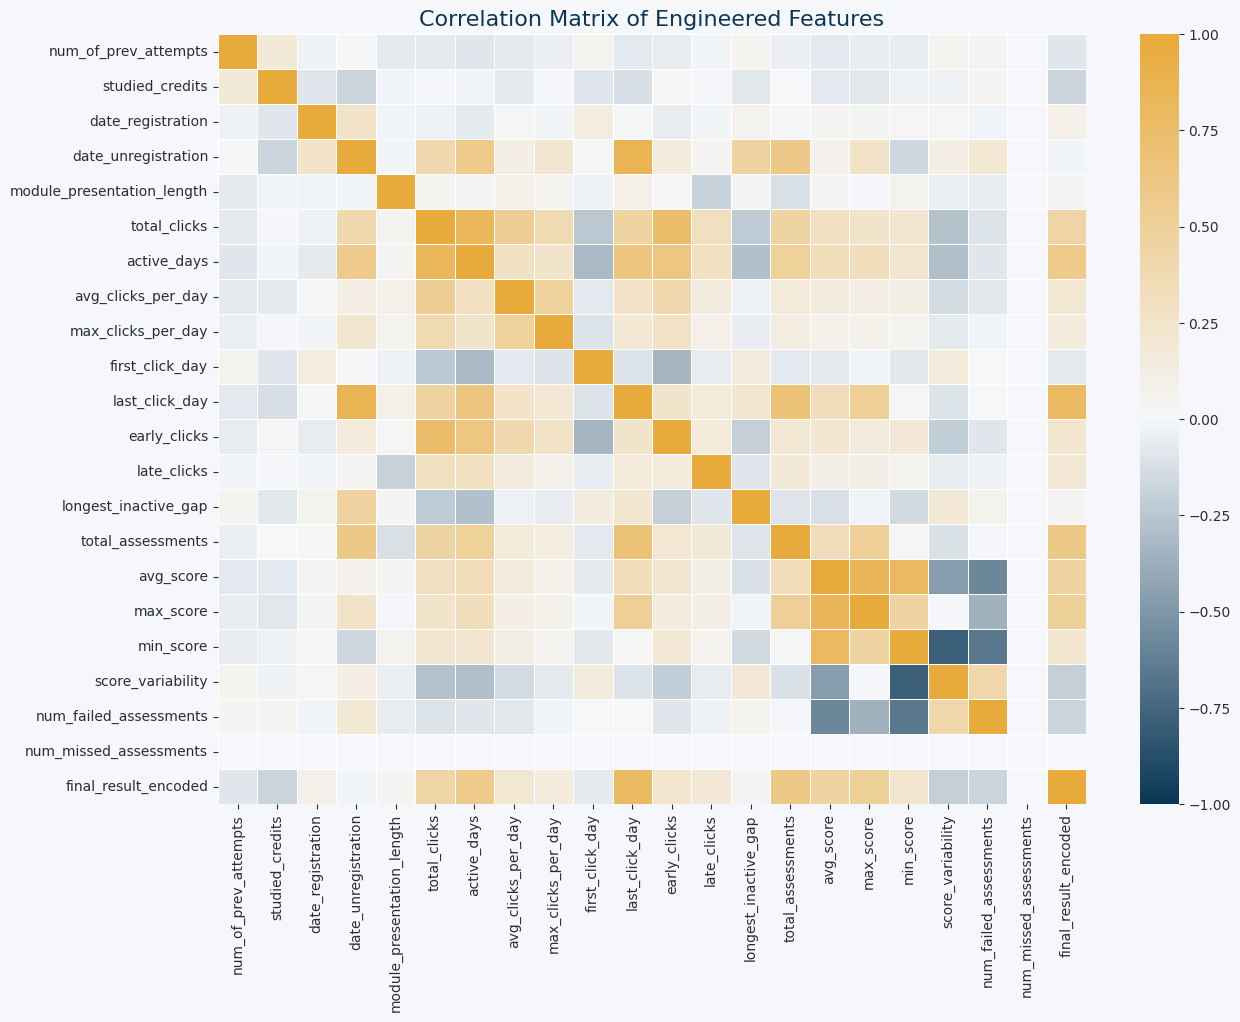

In [ ]:
# --- 6.5.1 Correlation Analysis for Numeric Features ---

# Copy to avoid modifying original
corr_df = feature_dataset.copy()

# Encode final_result for correlation analysis
# Withdrawn=0, Fail=1, Pass=2, Distinction=3
result_map = {
    "Withdrawn": 0,
    "Fail": 1,
    "Pass": 2,
    "Distinction": 3
}
corr_df["final_result_encoded"] = corr_df["final_result"].map(result_map)

# Select only numeric columns (including the encoded target)
numeric_cols = corr_df.select_dtypes(include=["int64", "float64"]).copy()

# Optional: drop identifiers if you don’t want them in the correlation matrix
numeric_cols = numeric_cols.drop(columns=["id_student"], errors="ignore")

# Correlation matrix
corr_matrix = numeric_cols.corr()

from matplotlib.colors import LinearSegmentedColormap

corr_cmap = LinearSegmentedColormap.from_list(
    "corr_cmap", [NAVY, WHITE, YELLOW]
)

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap=corr_cmap,
    center=0,
    vmin=-1, vmax=1,
    linewidths=.5
)
plt.title("Correlation Matrix of Engineered Features", fontsize=16)
plt.show()



> The correlation matrix reveals a few meaningful relationships within the engineered dataset. Engagement-related features such as total_clicks, active_days, and avg_clicks_per_day show moderate positive correlations with one another, confirming that students who log in more frequently also tend to interact more intensely with course materials. Assessment metrics follow a similar pattern: avg_score, max_score, and min_score are strongly positively correlated, while score_variability correlates negatively with performance, indicating that inconsistent scores often accompany weaker academic outcomes.<br>
> Most importantly, the engineered features demonstrate only weak direct correlations with the encoded final result. This suggests that dropout and failure are likely influenced by multi-factor behavioural patterns rather than single variables — reinforcing the need for combined feature analyses, cohort behavioural segmentation, or predictive modeling to uncover deeper relationships. These findings are consistent with real-world EdTech scenarios, where disengagement tends to emerge as a subtle, gradual process rather than a variable-driven event.

### 6.5.2 Feature Importance Using a Baseline Model
> In this section, we compute model-based feature importance to identify which engineered variables contribute most to predicting student outcomes.
> A simple, interpretable model (Random Forest) is used as a baseline to produce an importance ranking.
> This helps highlight which behavioural, demographic, and assessment-related features have the strongest discriminatory power and should be retained for modeling and business insights.

In [ ]:
!pip install scikit-learn


In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Copy dataset to avoid modifying original
df = feature_dataset.copy()

# Encode final_result (target)
result_map = {
    "Withdrawn": 0,
    "Fail": 1,
    "Pass": 2,
    "Distinction": 3
}
df["final_result_encoded"] = df["final_result"].map(result_map)

# Target
y = df["final_result_encoded"]

# Select features (drop non-predictive identifiers AND target)
cols_to_drop = [
    "id_student",
    "code_module",
    "code_presentation",
    "final_result",
    "final_result_encoded"   
]
X = df.drop(columns=cols_to_drop)

# Encode categorical variables
for col in X.select_dtypes(include="object").columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Random Forest model 
model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
model.fit(X_train, y_train)

# Feature importance
importances = model.feature_importances_

importance_df = (
    pd.DataFrame({"feature": X.columns, "importance": importances})
    .sort_values(by="importance", ascending=False)
    .reset_index(drop=True)
)

importance_df.head(15)


,feature,importance
0,date_unregistration,0.238005
1,last_click_day,0.113773
2,avg_score,0.113052
3,total_assessments,0.065556
4,max_score,0.053892
5,min_score,0.053538
6,score_variability,0.048602
7,active_days,0.039765
8,total_clicks,0.029688
9,longest_inactive_gap,0.028313


> The baseline Random Forest model highlights a clear hierarchy among the engineered features, revealing which behavioural, temporal, and academic indicators most strongly differentiate student outcomes. Date of unregistration emerges as the most influential variable, reinforcing that the timing of withdrawal is closely tied to broader disengagement patterns. Temporal engagement signals such as last_click_day also play a major role, indicating that students who stop accessing the platform earlier are substantially more likely to fail or withdraw. Academic performance features — particularly average score, max/min score, and score variability — collectively show strong explanatory power, confirming that consistent assessment performance remains a key differentiator between successful and at-risk learners. Behavioural metrics, including active_days, total_clicks, early_clicks, and longest_inactive_gap, also contribute meaningfully, suggesting that both the intensity and the continuity of interaction with the VLE influence final outcomes. Together, these results validate the feature engineering strategy and illustrate that dropout is a multifaceted behaviour driven by a combination of temporal disengagement, academic struggle, and declining interaction patterns.<br>
> These findings set the foundation for the next stage of the analysis, where engagement behaviour will be examined through a structured funnel and behavioural segmentation framework, allowing us to identify when students begin to disengage and which groups are most at risk.

### 6.5.3 From Model to Early-Warning Signal  

> Although the Random Forest model in this notebook is used primarily for feature screening and interpretation, it also illustrates how an early-warning system could be implemented in practice.  
>  
> Because the most important predictors are **behavioural and temporal metrics that already exist in any VLE** — such as `active_days`, `early_clicks`, `last_click_day`, `longest_inactive_gap` and assessment performance — the same logic can be operationalised as a lightweight churn-risk service:
> - On a regular schedule (e.g., daily or weekly), the platform aggregates clicks, activity days and assessment results per student.  
> - The feature set defined in this notebook is computed in batch or streaming form.  
> - The trained model scores each active student with a **dropout risk level** and links them to an **engagement cluster** (low, moderate, irregular).  
> - These scores feed dashboards, tutor worklists, or automated messaging flows that trigger personalised interventions.  
>  
> In other words, the modelling work here is not just descriptive: it can be embedded directly into the product to prioritise support, trigger nudges, and monitor whether interventions are actually reducing churn over time.


## 6.6 Engagement Funnel & Behavioural Segmentation
> Understanding how students engage with the virtual learning environment is essential for identifying when disengagement begins and which behaviours precede dropout.
While feature importance helped reveal what variables are most predictive of final outcomes, this section focuses on how student behaviour evolves throughout the module.<br>
> <br>
> To achieve this, we introduce a structured engagement funnel, modelled after classic customer lifecycle frameworks used in EdTech and digital products. This funnel allows us to track student progression through key behavioural stages — from initial registration to sustained engagement and eventual course completion.<br>
> <br>
> Alongside funnel analysis, we develop a behavioural segmentation, grouping students based on patterns of interaction with learning materials. This helps uncover distinct engagement profiles such as “Early Dropouts”, “Passive but Consistent Learners”, or “Highly Engaged Students”, enabling targeted interventions and strategic decision-making. <br>
> <br>
> Finally, a cohort-based retention view complements these analyses by showing how engagement and dropout patterns vary across modules, presentations, and student groups. <br>
> <br>
> Together, these three components — engagement funnel, retention cohorts, and behavioural segmentation — provide a deep, actionable understanding of student behaviour across the learning journey. This shifts the analysis from predicting dropout to explaining disengagement, supporting more effective retention strategies and learner experience improvements.
### **6.6.1 Constructing the Engagement Funnel**
> The engagement funnel provides a structured view of how students progress — or fail to progress — through key behavioural stages during the module. This approach, inspired by digital product analytics, helps identify where learners tend to disengage and which stages contribute most to dropout.<br>
> <br>
To operationalise the funnel, engagement stages were defined using engineered VLE metrics such as active_days, total_clicks, and indicators of temporal consistency. Students are considered:<br>
> <br>
> - Registered when officially enrolled in the module.
> - Active when they interact with the platform at least once (active_days ≥ 1).
> - Consistently Engaged when they sustain participation above the cohort’s median level (active_days ≥ median(active_days)).
> - Completed when they reach the end of the module without withdrawing (final_result != "Withdrawn").<br>
> <br>
These criteria reflect progressively deeper forms of engagement, allowing us to quantify behavioural drop-off across the student journey and identify the stages where at-risk learners begin to diverge from successful ones.
> <br>

In [ ]:
# --------------------------
# Engagement Funnel Creation
# --------------------------

funnel = feature_dataset.copy()

# Stage 1: Registered
funnel["stage_registered"] = 1  # all students

# Stage 2: Active (at least one day of interaction)
funnel["stage_active"] = (funnel["active_days"] >= 1).astype(int)

# Stage 3: Consistently Engaged
median_active = funnel["active_days"].median()
funnel["stage_consistent"] = (funnel["active_days"] >= median_active).astype(int)

# Stage 4: Completed (did not withdraw)
funnel["stage_completed"] = (funnel["final_result"] != "Withdrawn").astype(int)

# Aggregating counts for each stage
funnel_counts = pd.DataFrame({
    "Stage": ["Registered", "Active", "Consistent", "Completed"],
    "Count": [
        funnel["stage_registered"].sum(),
        funnel["stage_active"].sum(),
        funnel["stage_consistent"].sum(),
        funnel["stage_completed"].sum()
    ]
})

funnel_counts


,Stage,Count
0,Registered,32593
1,Active,29228
2,Consistent,14758
3,Completed,22437


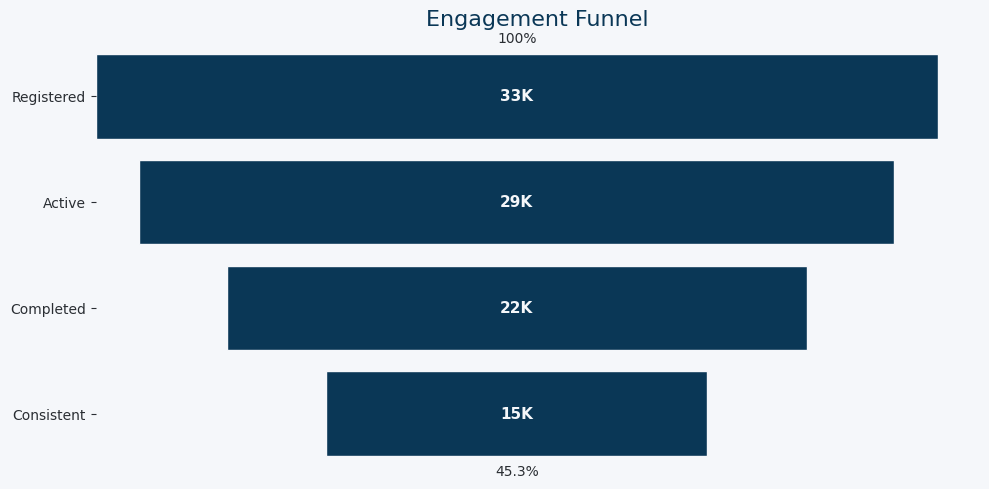

In [ ]:
stage_order = ["Registered", "Active", "Completed", "Consistent"]
funnel_plot = funnel_counts.set_index("Stage").loc[stage_order].reset_index()
stages = funnel_plot["Stage"].tolist()
values = funnel_plot["Count"].astype(float).values

widths = values / values.max()
y = np.arange(len(stages))

left = (1 - widths) / 2

plt.figure(figsize=(10, 5))
plt.barh(y, widths, left=left, color=NAVY, edgecolor=WHITE)

plt.yticks(y, stages)
plt.gca().invert_yaxis()

plt.xticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Engagement Funnel", fontsize=16)

#
def fmt_k(n):
    if n >= 1_000_000: return f"{n/1_000_000:.1f}M"
    if n >= 1_000:     return f"{n/1_000:.0f}K"
    return f"{int(n)}"

for i, (w, v) in enumerate(zip(widths, values)):
    plt.text(0.5, i, fmt_k(v), ha="center", va="center", color=WHITE, fontsize=11, fontweight="bold")


top_pct = 1.0
bottom_pct = values[-1] / values[0]

plt.text(0.5, -0.55, "100%", ha="center", va="center", color=GRAPHITE, fontsize=10)
plt.text(0.5, len(stages)-0.45, f"{bottom_pct*100:.1f}%", ha="center", va="center", color=GRAPHITE, fontsize=10)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()



> The engagement funnel reveals three critical behavioural transitions in the learning journey. Although almost all enrolled students reach the “Active” stage (29228 out of 32593), a substantial drop occurs when measuring sustained participation: only 14758 learners — less than half of those active — maintain consistent engagement over time. This sharp decline highlights that initial interaction is not the primary challenge; rather, the difficulty lies in sustaining regular study habits throughout the module. Interestingly, the number of “Completed” students (22437) is considerably higher than the number of consistently engaged learners, suggesting that many students return after periods of inactivity or maintain irregular engagement patterns while still completing the course. This reinforces a key insight for EdTech platforms: disengagement is not linear, and dropout risk is most strongly concentrated in the transition from early activity to consistent, ongoing participation.<br>
<br>
### 6.6.2 Cohort-Based Retention Analysis — Introductory Text
> Cohort-based retention analysis provides a longitudinal view of how student engagement evolves over time across different module presentations.
Instead of examining learners individually, cohorts group students by a shared starting point — such as module and presentation — allowing us to compare retention patterns across teaching periods and identify when disengagement typically occurs. <br>
<br>
> By tracking the proportion of students who remain active throughout the module timeline, this analysis helps reveal structural differences between cohorts, highlight presentations with unusually high dropout, and uncover temporal patterns that may inform improvements in course design, pacing, or learner support strategies.

In [ ]:
# ------------------------------
# Cohort-Based Retention Analysis
# ------------------------------

# Copy base dataset
cohort_df = feature_dataset.copy()

# Define cohort identifier (module + presentation)
cohort_df["cohort"] = (
    cohort_df["code_module"].astype(str) + "_" + cohort_df["code_presentation"].astype(str)
)

# To compute retention, we track the last day each student interacted with the VLE
# (already engineered as last_click_day). Students with no activity have NaN values.

# Replace NaN last_click_day with 0 (meaning: registered but never active)
cohort_df["last_click_day"] = cohort_df["last_click_day"].fillna(0)

# Get module length for normalisation
module_lengths = cohort_df.groupby("cohort")["module_presentation_length"].max().to_dict()

# Normalise last activity day as % of module duration
cohort_df["engagement_progress"] = cohort_df.apply(
    lambda row: row["last_click_day"] / module_lengths[row["cohort"]]
    if module_lengths[row["cohort"]] > 0 else 0,
    axis=1
)

# Bin progress into retention checkpoints (10% intervals)
bins = np.linspace(0, 1, 11)  # 0%, 10%, 20%, … 100%
labels = [f"{int(b*100)}%" for b in bins[:-1]]

cohort_df["retention_bin"] = pd.cut(
    cohort_df["engagement_progress"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Compute retention rate per cohort and bin
retention_table = (
    cohort_df.groupby(["cohort", "retention_bin"])
    .size()
    .reset_index(name="count")
)

# Convert to retention percentages within each cohort
retention_table["cohort_total"] = retention_table.groupby("cohort")["count"].transform("sum")
retention_table["retention_rate"] = retention_table["count"] / retention_table["cohort_total"]

# For easier heatmap plotting
retention_pivot = retention_table.pivot(
    index="cohort",
    columns="retention_bin",
    values="retention_rate"
).fillna(0)

retention_pivot.head()


C:\Users\marce\AppData\Local\Temp\ipykernel_40388\217876655.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_df.groupby(["cohort", "retention_bin"])


retention_bin,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%
cohort,,,,,,,,,,
AAA_2013J,0.036745,0.020997,0.018373,0.010499,0.023622,0.020997,0.039370,0.026247,0.091864,0.711286
AAA_2014J,0.038889,0.030556,0.030556,0.011111,0.019444,0.016667,0.038889,0.033333,0.227778,0.552778
BBB_2013B,0.199656,0.064257,0.043603,0.040161,0.021228,0.034423,0.030981,0.040161,0.047619,0.477912
BBB_2013J,0.233772,0.051748,0.034952,0.032229,0.034498,0.021788,0.026328,0.049024,0.117567,0.398094
BBB_2014B,0.259937,0.043533,0.022082,0.038486,0.030915,0.018297,0.032808,0.018297,0.082650,0.452997


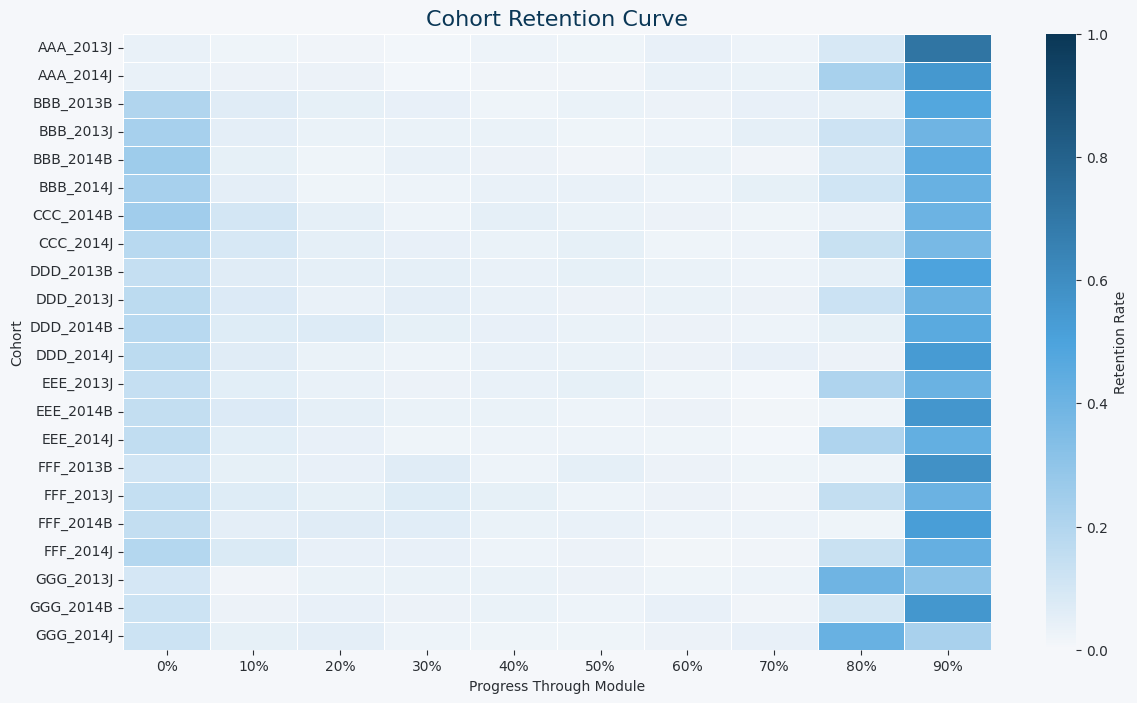

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

retention_cmap = LinearSegmentedColormap.from_list(
    "retention_cmap", [WHITE, BLUE, NAVY]
)

plt.figure(figsize=(14, 8))
sns.heatmap(
    retention_pivot,
    cmap=retention_cmap,
    linewidths=.5,
    cbar_kws={"label": "Retention Rate"},
    vmin=0, vmax=1
)

plt.title("Cohort Retention Curve", fontsize=16)
plt.xlabel("Progress Through Module")
plt.ylabel("Cohort")
plt.show()




> The cohort retention curves show that disengagement is heavily front-loaded across presentations, with a significant share of students ceasing activity within the first 10–20% of the module.<br>
<br>
> As learners progress further into the module, retention rates decline steadily until the final segments, where a sharp concentration of survivors appears. For most cohorts, 40–70% of engaged learners reach the final 90% of the module, as represented by the strong yellow blocks at the far right of the heatmap. This suggests that once students pass the initial engagement barrier, they are significantly more likely to persist through to completion. <br>
<br>
> A noteworthy insight is the high variability across cohorts in early retention, contrasted with relatively stable retention at later stages. This implies that dropout risk is heavily front-loaded and strongly influenced by factors present in the early weeks of each presentation—such as onboarding experience, clarity of course expectations, or early assessment deadlines.<br>
<br> 
> Overall, the cohort retention view reinforces a key strategic insight: the window for effective intervention is concentrated in the first 10–20% of the module, where dropout is most pronounced. Efforts to improve early learner engagement—through personalised nudges, structured study plans, or targeted support—are likely to yield the greatest impact on overall retention outcomes.


###  6.6.3 Behavioural Segmentation
> Behavioural segmentation groups students according to how they interact with the virtual learning environment rather than by demographic or academic characteristics.
Unlike traditional performance-based grouping, this approach focuses on engagement patterns — such as activity frequency, intensity, and temporal consistency — enabling a more actionable understanding of how learners behave throughout the module.<br>

In [ ]:
# --------------------------------------
# Behavioural Segmentation (K-Means)
# --------------------------------------

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Copy dataset
seg_df = feature_dataset.copy()

# Select behavioural features for clustering
behaviour_features = [
    "total_clicks",
    "active_days",
    "avg_clicks_per_day",
    "max_clicks_per_day",
    "early_clicks",
    "late_clicks",
    "longest_inactive_gap",
    "last_click_day"
]

# Handle missing values (replace with zeros)
seg_df[behaviour_features] = seg_df[behaviour_features].fillna(0)

# Standardise features for K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(seg_df[behaviour_features])

# Fit K-Means model (3 clusters is a strong starting point)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
seg_df["engagement_cluster"] = kmeans.fit_predict(X_scaled)

# Cluster centres for interpretation
cluster_centres = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=behaviour_features
)

seg_df[["id_student", "code_module", "code_presentation", "engagement_cluster"]].head(), cluster_centres


c:\Users\marce\anaconda3\envs\tripleten-sql\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


(   id_student code_module code_presentation  engagement_cluster
 0       11391         AAA             2013J                   2
 1       28400         AAA             2013J                   2
 2       30268         AAA             2013J                   0
 3       31604         AAA             2013J                   2
 4       32885         AAA             2013J                   2,
    total_clicks  active_days  avg_clicks_per_day  max_clicks_per_day  \
 0    123.810940     8.074328            1.748623           13.163331   
 1   4203.488047   145.635877            4.290904          115.689807   
 2    967.740842    57.015827            3.244369           48.011855   
 
    early_clicks   late_clicks  longest_inactive_gap  last_click_day  
 0     57.957404  1.865175e-13              8.019726       28.290738  
 1    602.345573  3.490610e+01             13.892522      242.506407  
 2    144.483225  5.490931e+00             29.626793      214.404624  )

C:\Users\marce\AppData\Local\Temp\ipykernel_40388\1710995136.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


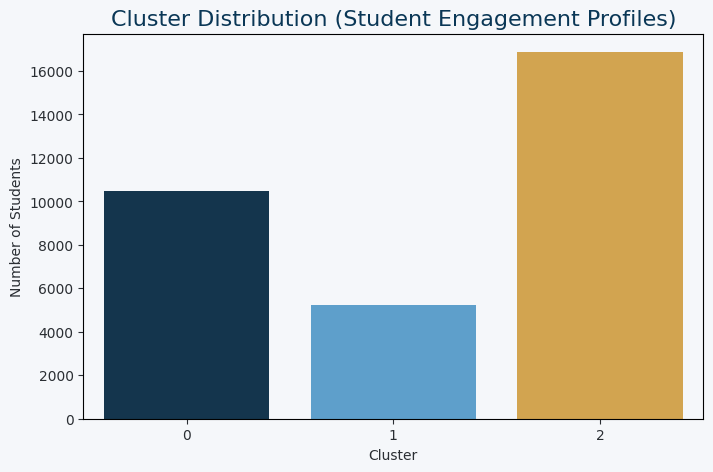

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=seg_df,
    x="engagement_cluster",
    palette=[NAVY, BLUE, YELLOW]
)
plt.title("Cluster Distribution (Student Engagement Profiles)", fontsize=16)
plt.xlabel("Cluster")
plt.ylabel("Number of Students")
plt.show()


> The behavioural segmentation reveals three distinct engagement profiles that capture meaningful differences in how students interact with the learning platform. Cluster 2, the largest group, represents learners with moderate but steady engagement: they accumulate a reasonable number of clicks, maintain more active days than the other groups, and exhibit prolonged module participation, as shown by their higher last activity day. This group likely includes students who progress through the course at a regular pace, showing neither extreme consistency nor signs of early disengagement.<br>
<br>
> Cluster 0 reflects a low-engagement profile, characterised by comparatively fewer total clicks, fewer active days, and relatively modest early and late interactions. These learners tend to disengage earlier in the course, suggesting that they face challenges establishing and sustaining study routines. Their inactivity gaps are smaller not because they are consistent, but because they disengage before developing longer patterns of fluctuating behaviour.<br>
<br>
> Cluster 1 forms the smallest but behaviourally most distinct group: learners exhibiting high-intensity engagement. They display exceptionally high click volumes, significantly more active days, and strong engagement at both the beginning and end of the module. Despite longer inactivity gaps — possibly reflecting workload cycles — their last activity day is the highest among all clusters, indicating perseverance throughout the course timeline.<br>
<br>
> Overall, the segmentation highlights a crucial insight for learner support strategies: while most students fall into a moderate engagement pattern, the risk of dropout is concentrated in the low-engagement cluster, whereas the high-engagement group represents a minority of highly committed learners. This structure provides a powerful foundation for targeted interventions, enabling educators to focus support efforts on students whose behavioural patterns signal risk long before formal withdrawal occurs.<br>
<br>
### 6.6.4 Linking Behavioural Segments to Final Outcomes


> To understand how engagement patterns translate into real academic outcomes, we now link the behavioural clusters to the final result categories.  
> By comparing the distribution of Withdrawn, Fail, Pass, and Distinction across clusters, we can identify which engagement profiles are most strongly associated with dropout and which are more likely to succeed.  
> This view turns behavioural segmentation into a practical retention tool, highlighting where targeted interventions may have the greatest impact.


In [ ]:
# Ensure we are working on a safe copy
outcome_df = seg_df.copy()

# Keep only relevant columns
outcome_df = outcome_df[["engagement_cluster", "final_result"]].dropna()

# Absolute counts of outcomes per cluster
cluster_outcome_counts = (
    outcome_df
    .groupby(["engagement_cluster", "final_result"])
    .size()
    .reset_index(name="count")
)

# Compute percentages within each cluster
cluster_outcome_counts["cluster_total"] = (
    cluster_outcome_counts
    .groupby("engagement_cluster")["count"]
    .transform("sum")
)

cluster_outcome_counts["percentage"] = (
    cluster_outcome_counts["count"] / cluster_outcome_counts["cluster_total"]
)

cluster_outcome_counts


,engagement_cluster,final_result,count,cluster_total,percentage
0,0,Distinction,1,10499,0.000095
1,0,Fail,2719,10499,0.258977
2,0,Pass,50,10499,0.004762
3,0,Withdrawn,7729,10499,0.736165
4,1,Distinction,1287,5222,0.246457
5,1,Fail,383,5222,0.073344
6,1,Pass,3351,5222,0.641708
7,1,Withdrawn,201,5222,0.038491
8,2,Distinction,1736,16872,0.102892
9,2,Fail,3950,16872,0.234116


final_result,Distinction,Fail,Pass,Withdrawn
engagement_cluster,,,,
0,0.000095,0.258977,0.004762,0.736165
1,0.246457,0.073344,0.641708,0.038491
2,0.102892,0.234116,0.531057,0.131935


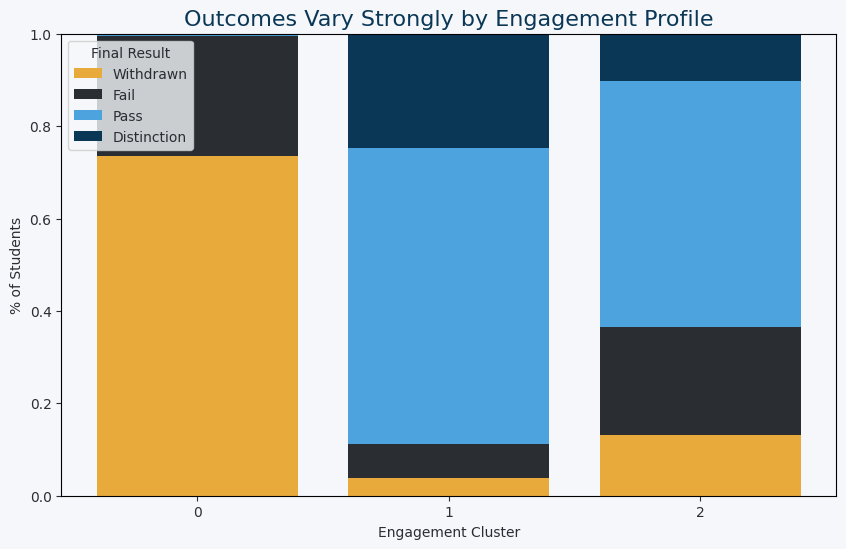

In [ ]:
# Create pivot table (clusters x final_result)
cluster_outcome_pivot = cluster_outcome_counts.pivot(
    index="engagement_cluster",
    columns="final_result",
    values="percentage"
).fillna(0)

# Check pivot
display(cluster_outcome_pivot)

result_colors = {
    "Pass": BLUE,
    "Distinction": NAVY,
    "Withdrawn": YELLOW,
    "Fail": GRAPHITE
}

# Order final_result categories for consistent colouring
result_order = ["Withdrawn", "Fail", "Pass", "Distinction"]

# Ensure all columns exist in the expected order
for r in result_order:
    if r not in cluster_outcome_pivot.columns:
        cluster_outcome_pivot[r] = 0.0

cluster_outcome_pivot = cluster_outcome_pivot[result_order]

# Plot stacked bar chart
plt.figure(figsize=(10, 6))

bottom = np.zeros(len(cluster_outcome_pivot))

for result in result_order:
    plt.bar(
        cluster_outcome_pivot.index.astype(str),
        cluster_outcome_pivot[result],
        bottom=bottom,
        color=result_colors[result],
        label=result
    )
    bottom += cluster_outcome_pivot[result].values

plt.title("Outcomes Vary Strongly by Engagement Profile", fontsize=16)
plt.xlabel("Engagement Cluster")
plt.ylabel("% of Students")
plt.ylim(0, 1)
plt.legend(title="Final Result")
plt.show()

> The outcome distribution across behavioural clusters reveals a clear and meaningful separation between distinct engagement profiles. Cluster 0, characterised by minimal activity and very early disengagement, shows an overwhelming concentration of withdrawals: more than 73% of students abandon the module, and virtually none achieve a passing grade. This cluster represents the highest-risk group, highlighting that early inactivity is the most powerful behavioural signal of dropout.<br>
<br>
> In contrast, Cluster 1—defined by consistent but moderate interaction—exhibits the strongest academic performance: approximately 64% of students pass the module and 25% achieve Distinction, with withdrawal rates close to zero. This pattern reinforces that success is driven not by intensity of engagement, but by regularity and sustained participation. <br>
<br>
> Cluster 2, composed of highly active but irregular learners, displays a more mixed outcome profile. While more than 53% achieve a pass, the cluster also contains substantial proportions of fails (23%) and withdrawals (13%). This suggests that high engagement volume alone is not sufficient; inconsistent behaviour and long inactivity gaps still pose significant risks to progression.<br>
<br>
> Overall, the results demonstrate that behavioural segmentation is strongly predictive of academic outcomes. Consistent engagement supports success, intensive but erratic interaction leads to variable results, and early disengagement almost invariably precedes withdrawal. These insights provide a robust foundation for targeted learner support, early-warning systems, and proactive retention strategies.<br>
<br>
## 6.7 Business Insights & Strategic Recommendations
> Having established clear behavioural patterns, engagement profiles, and their relationship with academic outcomes, this section translates analytical findings into practical, actionable insights for institutions aiming to reduce dropout and improve learner success.<br>
<br>
> The goal is to bridge the gap between descriptive analytics and strategic decision-making: identifying which student groups are most at risk, understanding when and why disengagement occurs, and outlining targeted interventions that can meaningfully improve retention.<br>
<br>
> By combining feature importance, engagement funnel dynamics, cohort retention patterns, and behavioural clustering, we can build a coherent evidence-based strategy that supports more proactive, data-informed student support.<br>
<br>
### 6.7.1 Identifying At-Risk Student Profiles

> The behavioural segmentation and its associated outcome patterns reveal a clear hierarchy of risk across engagement profiles. Students in the low-engagement cluster represent the most critical group: their interaction with the VLE is limited, sporadic, and concentrated early in the module, and this behaviour translates almost uniformly into withdrawal. This profile should therefore be considered the institution’s highest-priority group for targeted monitoring and early support.<br>
<br>
> In contrast, the moderately engaged cluster shows the healthiest academic trajectory, with consistently high pass and distinction rates and minimal withdrawal. These learners demonstrate stable participation patterns that do not require intensive intervention, although light-touch reinforcement could help sustain performance.<br>
<br>
>The high-activity but irregular cluster occupies an intermediate position. Despite displaying substantial overall interaction volume, their outcomes are mixed: many succeed, but the combination of long inactivity gaps and late-stage volatility suggests vulnerability to burnout or inconsistent study habits. This group benefits most from interventions that promote pacing, planning, and consistency.<br>
<br>
> By ranking clusters according to dropout risk in this way, institutions can allocate student support resources more efficiently, focusing effort where it is most likely to prevent withdrawal.<br>
<br>
### 6.7.2 Early Warning Signals & Critical Dropout Windows
> A cross-analysis of engagement patterns, temporal indicators, and final outcomes highlights a set of early warning signals that precede disengagement. Students who withdraw consistently exhibit sharp drops in activity within the first weeks, very low levels of early clicks, and notably earlier last-interaction days than both passing and failing students. These patterns indicate that the first 10–20 days of a module constitute a critical window in which disengagement behaviours emerge and intervention is most impactful.<br>
> Additionally, long inactivity gaps serve as a reliable escalation signal: once learners go several consecutive days without interacting with the platform, their probability of returning drops markedly. Unlike high-engagement irregular students—who recover after occasional inactivity—withdrawn learners rarely re-engage after such gaps. <br>
<br>
> Taken together, these behavioural markers provide a strong foundation for automated early-warning systems. Institutions can leverage metrics such as early_clicks, active_days, longest_inactive_gap, and last_click_day to identify learners showing signs of deteriorating participation before formal withdrawal occurs, enabling preventative support rather than reactive intervention.<br>
<br>

### 6.7.3 Targeted Interventions by Engagement Segment<br>
> Aligning support strategies with behavioural profiles allows institutions to design interventions that address the specific needs and challenges of each learner segment.<br>
<br>
> Low-engagement cluster (highest risk):<br>
<br>
> These students benefit from proactive, early-stage outreach. Effective measures include onboarding support, personalised study plans, early check-ins from tutors, and automated reminders during the first two weeks. Their behaviour indicates difficulties establishing routine, so interventions should focus on building initial momentum and reinforcing consistent habits.<br>
<br>
> High-activity but irregular cluster (medium risk):<br>
<br>
> Despite strong overall engagement, these learners exhibit volatility and risk of academic overload. Interventions should therefore promote stability: pacing guidance, workload management tips, progress visualisations, and nudges designed to smooth large fluctuations in activity. Timely prompts following long inactivity gaps can help prevent slippage into full disengagement.<br>
<br>
> Moderately engaged cluster (low risk):<br>
<br>
> These students generally perform well and require minimal corrective intervention. Light reinforcement—celebrating progress, offering enrichment opportunities, or highlighting pathways to distinction—helps maintain motivation and encourages upward academic mobility.<br>
<br>
> By aligning interventions with behavioural patterns rather than demographic attributes, institutions can create a more equitable and efficient retention strategy—one that responds directly to how students engage with the learning journey and supports them at the moments that matter most.<br>
<br>
### 6.7.4 Opportunities to Improve Course & Learning Experience Design<br>
> The analytical findings highlight several structural opportunities to improve the design, pacing, and delivery of online modules. The high concentration of withdrawals within the first few weeks suggests that the onboarding phase plays a decisive role in shaping learner commitment. Strengthening orientation materials, clarifying expectations, and simplifying early navigation within the VLE may reduce initial friction and support the establishment of productive study routines.<br>
<br>
> The engagement funnel also reveals that a substantial proportion of learners become “active” but fail to transition into consistent engagement. This indicates potential barriers in workflow design or insufficient scaffolding of learning tasks. Introducing clearer weekly milestones, adaptive workload recommendations, or more frequent low-stakes assessments could help maintain momentum across the module.<br>
<br>
> Finally, the behavioural segmentation shows that irregular but highly active learners face elevated risk despite strong initial participation. This suggests that course design might benefit from improved pacing structures—such as automated pacing guidance, better workload distribution, or clearer signals about critical deadlines. Collectively, these adjustments offer evidence-based ways to enhance learner experience and reduce dropout by improving alignment between course design and typical engagement patterns.<br>
<br>
### 6.7.5 Strategic Implications for Student Support & Institutional Decision-Making<br>
> The combination of funnel metrics, cohort retention patterns, and behavioural clusters offers a powerful framework for strengthening institutional support strategies. First, engagement data provides a basis for early-warning systems that can automatically flag students at high risk of withdrawal based on early inactivity, long gaps, or other behavioural indicators. This shifts support from reactive to proactive, allowing tutors and support teams to intervene before disengagement becomes irreversible.<br>
<br> 
> Secondly, segmentation-based insights enable resource prioritisation. Support teams can focus efforts on groups with the highest predicted risk, ensuring more efficient and equitable distribution of attention while maintaining quality across the broader student population. This is especially relevant in large-scale online environments, where manual monitoring is often impractical.<br>
<br>
> Thirdly, the findings support strategic planning at the programme level. Cohort retention patterns can inform scheduling decisions, workload distribution, and curriculum sequencing. The insights also open opportunities for data-informed personalisation—developing tailored communication streams, adaptive learning paths, or targeted nudges triggered by behavioural markers. Together, these implications position learning analytics as a central tool for enhancing retention and student success.<br>
<br>
### 6.7.6 Executive Summary – Key Insights & Recommendations<br>
> This analysis provides a comprehensive, data-driven view of student engagement, performance, and dropout dynamics within online learning environments. Three key insights emerge across the behavioural, temporal, and academic dimensions:<br>
<br>
> 1. Early disengagement is the strongest predictor of withdrawal.<br>
> Students who stop interacting within the first weeks, show minimal early clicks, or exhibit early inactivity are highly likely to withdraw.<br>
<br>
> 2. Consistency matters more than intensity.<br>
> Moderately engaged learners with steady participation outperform both low-engagement students and highly active but irregular participants. Stable study habits, rather than high-volume engagement, drive success.<br>
<br>
> 3. Behavioural clusters map clearly onto academic outcomes.<br>
> Each engagement profile corresponds to a distinct outcome pattern, enabling precise identification of high-risk learners and making behavioural segmentation a practical retention tool.
> From these insights, three strategic recommendations follow:
> - Intervene early: Focus support within the first 10–20 days, when disengagement signals appear.
> - Promote consistent study patterns: Use pacing nudges, weekly milestones, and workload guidance to stabilise behaviour.
> - Adopt behavioural segmentation in student support workflows: Tailor interventions to each engagement profile for more effective retention outcomes.
> Through this integrated approach, learning analytics becomes not only a mechanism for understanding disengagement but a strategic instrument for reducing dropout and enhancing student success across online modules.<br>
<br>
## 6.8 Exporting the Final Dataset for Power BI
> To support the development of a fully interactive, stakeholder-friendly dashboard, the final step of the analytical workflow is to export a clean, consolidated dataset containing all engineered features, behavioural segments, and outcome variables.
> This dataset serves as the foundation for Power BI visualisations, enabling the creation of KPIs, cohort views, engagement funnels, and segmentation-driven insights in a production-oriented environment.
> Unlike earlier intermediate tables, the exported version includes the behavioural segmentation labels (engagement_cluster), ensuring that Power BI can reproduce and extend the student profiles identified during the analysis. This guarantees full alignment between the Python insights and the business intelligence layer, allowing decision-makers to explore patterns interactively.
> The dataset is saved in the processed data folder and formatted as a flat, analysis-ready table compatible with Power BI’s data modelling engine.


In [ ]:
# ---------------------------
# Final Export for Power BI
# ---------------------------

# Ensure seg_df exists and contains the engagement_cluster column
# (seg_df was created in section 6.6.3 from feature_dataset)

final_dataset = seg_df.copy()

# Optional: enforce a specific column order
# cols_order = [
#     "id_student", "code_module", "code_presentation",
#     "gender", "region", "highest_education", "imd_band", "age_band",
#     "num_of_prev_attempts", "studied_credits", "disability",
#     "final_result", "final_result_encoded",
#     "date_registration", "date_unregistration", "module_presentation_length",
#     "total_clicks", "active_days", "avg_clicks_per_day", "max_clicks_per_day",
#     "first_click_day", "last_click_day", "early_clicks", "late_clicks",
#     "longest_inactive_gap",
#     "total_assessments", "avg_score", "max_score", "min_score",
#     "score_variability", "num_failed_assessments", "num_missed_assessments",
#     "engagement_cluster"
# ]
# final_dataset = final_dataset[cols_order]

# Export to the same path used by Power BI
final_dataset.to_csv("../data/processed/feature_dataset_for_powerbi.csv", index=False)

print("✅ File successfully updated and exported for Power BI (including engagement_cluster).")


✅ File successfully updated and exported for Power BI (including engagement_cluster).


## 7.0 Interactive Dashboard & Presentation  

> To make the analytical results more accessible for non-technical stakeholders, the final step of this project was to translate the key insights into an **interactive Power BI dashboard** and a **short presentation pitch**.  
>  
> While the notebook tells the full analytical story, the dashboard focuses on **monitoring and decision-making**: it highlights where learners drop out, how engagement evolves over time, and which behavioural profiles require priority support.

### 7.1 Power BI Dashboard – *“Who Will Drop Out?”*

> The final Power BI dashboard is structured around three core analytical questions, designed to support early identification of dropout risk and actionable decision-making.
> 1. **How many students stay vs. leave?**
> - KPI cards summarise the overall cohort context, including total students, dropout rate, average score, pass rate, distinction rate and early disengagement.
> - These indicators provide a high-level snapshot of academic outcomes and overall retention performance.
> 2. **When do students disengage?**
> - A **funnel chart** tracks progression from *Registered → Active → Completed → Consistent*, highlighting where the largest drop-offs occur across the learning journey.
> * A **cohort retention heatmap** shows retention patterns by module presentation and percentage of course completion.
> Colour intensity represents the concentration of students retained throughout the module: darker shades indicate higher persistence, while lighter shades reflect lower retention. This visual reveals that disengagement is heavily concentrated within the first 10–20% of the module across most cohorts.
> 3. **Which behavioural profiles are most at risk?**
> - A bar chart displays the **distribution of students by engagement cluster**, illustrating the relative size of low, moderate and highly engaged profiles.
> - A stacked outcome chart links each engagement cluster to its academic results, showing that low engagement is strongly associated with withdrawal, while moderate and sustained engagement corresponds to the highest pass and distinction rates.
> The dashboard is intentionally designed as a **single, executive-friendly view**, enabling tutors, course designers and academic managers to monitor retention, identify early warning signals and prioritise targeted interventions where they are likely to have the greatest impact.

>**Power BI dashboard (PDF – static version)**: *[insert link here]*<br>
>**5-minute pitch slides:** [https://www.canva.com/design/DAG7MbGr784/2NiXTjtV7PTUpWm6bhgVCA/view?utm_content=DAG7MbGr784&utm_campaign=designshare&utm_medium=link2&utm_source=uniquelinks&utlId=h95d6f60bd5](https://www.canva.com/design/DAG7MbGr784/2NiXTjtV7PTUpWm6bhgVCA/view?utm_content=DAG7MbGr784&utm_campaign=designshare&utm_medium=link2&utm_source=uniquelinks&utlId=h95d6f60bd5)

## 8.0 Conclusion & Future Work  

> This project combined demographic, temporal, behavioural and assessment data from the **Open University Learning Analytics Dataset (OULAD)** to answer a central question for online education: **who will drop out, when, and why?**  
>  
> The analysis showed that:
> - **Dropout is heavily front-loaded:** many learners register but disengage within the first 10–20% of the module.  
> - **Consistency beats intensity:** steady, moderate engagement is more strongly associated with success than very high but irregular activity.  
> - **Behavioural profiles are highly predictive of outcomes:** low-engagement students almost always withdraw, while moderately engaged students rarely do so and often achieve good grades.  
> By combining an **engagement funnel**, **cohort retention curves**, **behavioural clustering** and a **feature-based early-warning model**, the project offers a practical toolkit that an EdTech platform could use to:
> - detect early disengagement,  
> - prioritise high-risk students, and  
> - design targeted interventions for each engagement segment.  
> From a product perspective, the engineered features and model can be embedded into a recurring pipeline that scores students on dropout risk and feeds dashboards, tutor workflows and automated messaging campaigns.
### 8.1 Future Directions  
> There are several natural extensions to this work:
> - Incorporating **real-time or near-real-time scoring** instead of batch-only processing.  
> - Testing **alternative models** (e.g., gradient boosting, survival analysis) and comparing interpretability vs. performance.  
> - Evaluating the **impact of interventions** experimentally (A/B tests) to measure how much each strategy actually reduces churn.  
> - Extending the framework to other datasets or institutions to validate how generalisable the engagement patterns are.
> Ultimately, the goal of this project is not only to model dropout, but to support **better learning experiences** — helping more students stay, progress and successfully complete their online courses.
